In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
from utils import make_nice_plots
make_nice_plots()

In [4]:
origin_dict = {}

post_path = '/net/vdesk/data2/pouw/MRP/mockdata_analysis/darksirenpop/inputs/posterior_samples_mock_v4.json'  # '/net/vdesk/data2/pouw/MRP/scripts/gwcosmo_inputs/gw_jsons/posterior_samples_cosmo.json'
with open(post_path) as f:
    posterior_samples_dictionary = json.load(f)

for key, filename in posterior_samples_dictionary.items():
    with h5py.File(filename, 'r') as f:
        origin_dict[key] = f['mock']['truths']['from_agn'][()].astype(bool)


In [5]:
pagn = np.load('pagn_sky_v5.npy')
palt = np.load('palt_sky_v5.npy')

In [6]:
def get_colors(origin_dict):
    colors = np.zeros(len(origin_dict), dtype=str)
    for i, value in enumerate(origin_dict.values()):
        if value:
            colors[i] = 'blue'
        else:
            colors[i] = 'red'
    return colors

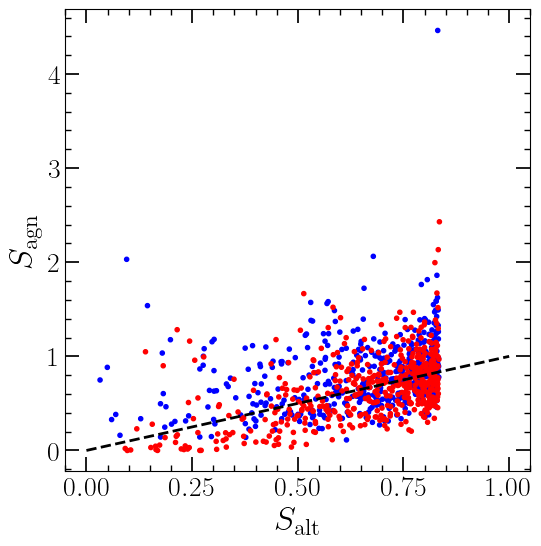

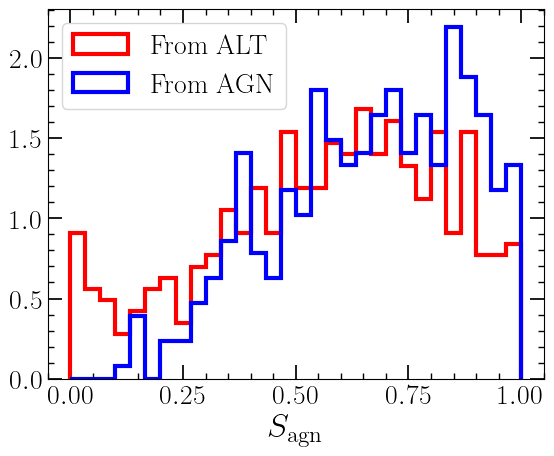

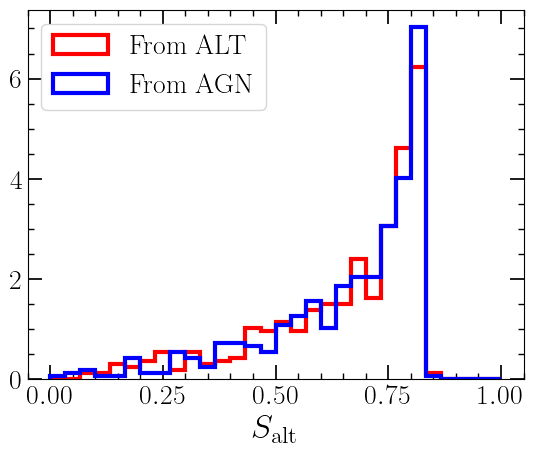

In [7]:
xmin = 0  # min(np.min(pagn), np.min(palt))
xmax = 1  # max(np.max(pagn), np.max(palt))
xx = np.linspace(xmin, xmax, 100)

plt.figure(figsize=(6,6))
plt.scatter(palt, pagn, marker='.', color=get_colors(origin_dict))
plt.plot(xx, xx, color='black', linestyle='dashed', linewidth=2)
# plt.loglog()
plt.xlabel(r'$S_{\rm alt}$')
plt.ylabel(r'$S_{\rm agn}$')
plt.savefig('evidence_v3.pdf', bbox_inches='tight')
plt.show()

origins = np.array([val for val in origin_dict.values()])

edges = np.linspace(xmin, xmax, 31)
plt.figure()
plt.hist(pagn[~origins], bins=edges, density=True, histtype='step', color='red', linewidth=3, label='From ALT')
plt.hist(pagn[origins], bins=edges, density=True, histtype='step', color='blue', linewidth=3, label='From AGN')
# plt.semilogx()
plt.legend()
plt.xlabel(r'$S_{\rm agn}$')
plt.show()

plt.figure()
plt.hist(palt[~origins], bins=edges, density=True, histtype='step', color='red', linewidth=3, label='From ALT')
plt.hist(palt[origins], bins=edges, density=True, histtype='step', color='blue', linewidth=3, label='From AGN')
# plt.semilogx()
plt.legend()
plt.xlabel(r'$S_{\rm alt}$')
plt.show()


/var/tmp/pouw/ipykernel_3731639/429315778.py:27: RuntimeWarning: divide by zero encountered in log
  log_llh_numerator_per_event = np.log(fagn * total_prob_agn + (1 - fagn) * total_prob_alt)


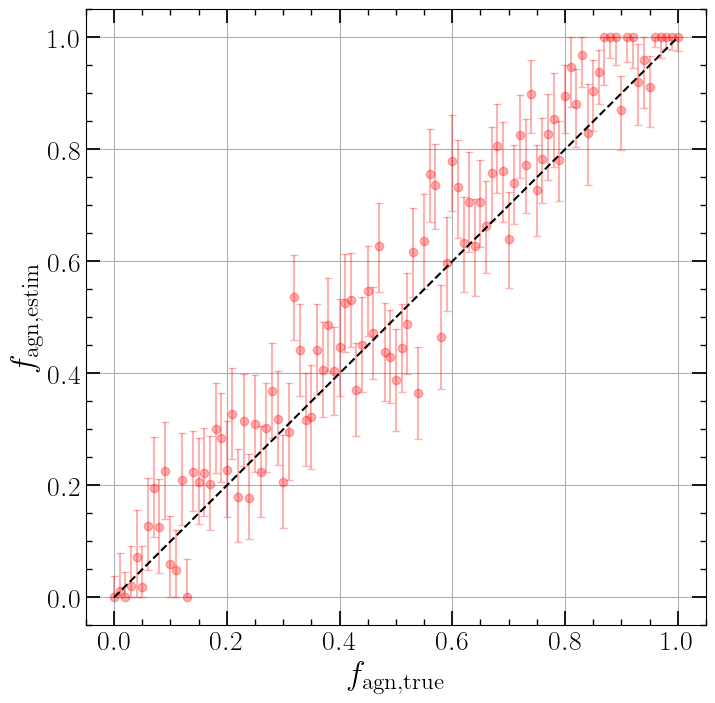

In [19]:
use_N_gws = 500
N_true_fagns = min(use_N_gws+1, 101)  # Cannot create more f_agn values than use_N_gws+1 and don't want to generate more than 101
calc_logllh_at_N_points = 1000  # Only change if you want higher resolution, but why would you?
log_llh_x_ax = np.linspace(0.0001, 1., calc_logllh_at_N_points)

true_fagns = np.zeros((N_true_fagns, calc_logllh_at_N_points))
estimated_fagns = np.zeros((N_true_fagns, calc_logllh_at_N_points))
lowers = np.zeros((N_true_fagns, calc_logllh_at_N_points))
uppers = np.zeros((N_true_fagns, calc_logllh_at_N_points))

use_N_agn_events = np.arange(0, use_N_gws + 1, int(use_N_gws / (N_true_fagns-1)), dtype=np.int32)  # TODO: sample binomial distribution
use_N_alt_events = use_N_gws - use_N_agn_events
true_fagns = use_N_agn_events / use_N_gws

agn_events = origins
alt_events = ~origins

agn_idx = np.random.choice(np.where(agn_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
alt_idx = np.random.choice(np.where(alt_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
idx = np.where(np.arange(use_N_gws) < use_N_agn_events[:, None], agn_idx, alt_idx)  # Shape (N_true_fagns, use_N_gws)


fagn = log_llh_x_ax[:, np.newaxis, np.newaxis]
total_prob_agn = pagn[idx].T[np.newaxis,...]
total_prob_alt = palt[idx].T[np.newaxis,...]

log_llh_numerator_per_event = np.log(fagn * total_prob_agn + (1 - fagn) * total_prob_alt)

log_llh_numerator = np.sum(log_llh_numerator_per_event, axis=1)
log_llh_denominator = 0
log_llh = log_llh_numerator - log_llh_denominator

max_log_llh = np.max(log_llh, axis=0)
estimated_fagns = log_llh_x_ax[np.argmax(log_llh, axis=0)]

below_threshold = log_llh >= (max_log_llh - 0.5)  # For 68% CL

# Get first and last occurrence of True values along axis 0
first_valid = np.argmax(below_threshold, axis=0)
last_valid = log_llh_x_ax.shape[0] - 1 - np.argmax(below_threshold[::-1], axis=0)

lowers = estimated_fagns - log_llh_x_ax[first_valid]
uppers = log_llh_x_ax[last_valid] - estimated_fagns


# one_sigma = 0.68 * 

plt.figure(figsize=(8,8))
plt.errorbar(true_fagns, estimated_fagns, yerr=np.array([lowers, uppers]), capsize=3, linestyle='', marker='o', color='red', alpha=0.3)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6)
plt.xlabel(r'$f_{\rm agn, true}$')
plt.ylabel(r'$f_{\rm agn, estim}$')
# plt.legend()
plt.grid()
plt.show()

